<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/arima_sarima_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA Model for Time Series Forecasting

ARIMA (AutoRegressive Integrated Moving Average) is a model used to analyze and forecast time series data. It has three main components:

1. AR (AutoRegressive): The relationship between an observation and a number of lagged observations.
2. I (Integrated): The differencing of raw observations to make the time series stationary.
3. MA (Moving Average): The relationship between an observation and a residual error from a moving average model.

## 1. Import Preprocessed Data

In [12]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Load preprocessed data
df = pd.read_csv('preprocessed_bitcoin_data.csv', index_col='Date', parse_dates=True)

# Display the first few rows of the data
df.head()

,Close,High,Low,Open,Volume,Close_diff,Close_scaled
Date,,,,,,,
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,-32.894012,0.002325
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,-29.644012,0.002045
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,14.108002,0.002178
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,-10.082977,0.002083
2014-09-22,402.152008,406.915985,397.130005,399.100006,24127600,3.330994,0.002114


## ARIMA Model

In [6]:
# Define ARIMA model with chosen (p, d, q)
model = ARIMA(df['Close'], order=(2, 1, 2))  # Adjust (p, d, q) based on ACF/PACF
arima_result = model.fit()

# Print model summary
print(arima_result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3788
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -31374.752
Date:                Fri, 31 Jan 2025   AIC                          62759.504
Time:                        15:02:35   BIC                          62790.701
Sample:                             0   HQIC                         62770.594
                               - 3788                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5343      0.159      3.352      0.001       0.222       0.847
ar.L2          0.4333      0.160      2.715      0.007       0.120       0.746
ma.L1         -0.5682      0.163     -3.490      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


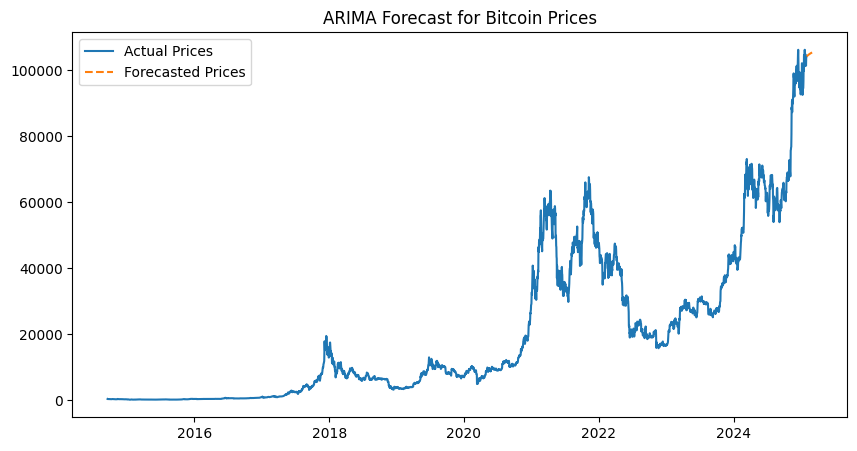

In [11]:
# Forecast future values
n_periods = 30  # Adjust based on how many days ahead you want to predict
forecast = arima_result.forecast(steps=n_periods)

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Close'], label='Actual Prices')
plt.plot(pd.date_range(df.index[-1], periods=n_periods+1, freq='D')[1:], forecast, label='Forecasted Prices', linestyle='dashed')
plt.legend()
plt.title('ARIMA Forecast for Bitcoin Prices')
plt.show()

## Evaluate Model Performance

In [14]:
# Get in-sample predictions
df['ARIMA_Pred'] = arima_result.predict(start=0, end=len(df)-1)

# Compute errors
mae = mean_absolute_error(df['Close'], df['ARIMA_Pred'])

# Compute RMSE (Root Mean Squared Error)
mse = mean_squared_error(df['Close'], df['ARIMA_Pred'])
rmse = np.sqrt(mse)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

NameError: name 'np' is not defined